<a href="https://colab.research.google.com/github/theofarouk/IMDA/blob/main/Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive language-image pretraining (CLIP)

CLIP model, developped by OpenAi in 2021, bridges the gap between images and text by placing them in a shared vector space. By using contrastive learning, CLIP learns to tell which image-text pairs belong together and which don’t.

This ability lets it generalize across different classes, even those it hasn’t encountered before. As a result, CLIP is highly effective at zero-shot classification, where it can accurately identify new categories based purely on text descriptions.

The gaol of this Lab is to discover these abilites.

First, we need to install the necessary libraries.

In [ ]:
!pip install transformers torch datasets

The jamescalam/image-text-demo dataset contains a small number of image-text pairs we can use in our examples.

In [ ]:
!pip install datasets==1.18.0

from datasets import load_dataset
ds = load_dataset("jamescalam/image-text-demo")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.3/311.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Downloading: 0.00B [00:00, ?B/s]

Downloading:   0%|          | 0.00/37.8M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset image_set downloaded and prepared to /root/.cache/huggingface/datasets/jamescalam___image_set/default/0.0.0/407740dbc70c0853dcd126ce90327d5a83d8ac5282831005a054df12d673ab58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from datasets import load_dataset
ds = load_dataset("jamescalam/image-text-demo")

Downloading: 0.00B [00:00, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data = ds["train"]

Initializing CLIP and an image/text preprocessor like so:

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

The model is CLIP itself. Note that we use the ViT image encoder (the model is clip-vit). Text and image data cannot be fed directly into CLIP. The text must be preprocessed to create “tokens IDs”, and images must be resized and normalized. The processor handles both of these functions.

**Encoding Text**
We will start with encoding text using the CLIP text transformer. Before feeding text into CLIP, it must be preprocessed and converted into token IDs. Let’s take a batch of sentences from the unsplash data and encode them.

In [ ]:
text = data['text']  # 21

tokens = processor(
    text=text,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)
tokens.keys()

KeysView({'input_ids': tensor([[49406, 12440,  2000,   539, 30987,  1305,   593,  3638, 31808, 49407,
         49407, 49407, 49407, 49407, 49407],
        [49406, 12440,  2000,   539,  4077,  1305,   536,  5610, 49407, 49407,
         49407, 49407, 49407, 49407, 49407],
        [49406,  9738,  8292,   525,   518,  8231,   539,   320,  2368, 49407,
         49407, 49407, 49407, 49407, 49407],
        [49406,  2242, 13063,  3941,  1417,  1538,  5922, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407],
        [49406, 17054,  1929, 21021,   620, 13626,   593,  4481,  5994, 49407,
         49407, 49407, 49407, 49407, 49407],
        [49406, 30987,  1305,   593,   912,  4350,  4730, 10113, 49407, 49407,
         49407, 49407, 49407, 49407, 49407],
        [49406, 30987,  6682,  1305,  2012,   953,  2443,   593,   736,   537,
          1746,  3073, 49407, 49407, 49407],
        [49406,  9718, 22192,  2368,   593,  1538,  6024,  2880, 11160,   525,
          9057,  2175, 49407, 

The input_ids are token ID values where each token ID is an integer value ID that maps to a specific word or sub-word. For example the phrase “multi-modality” may be split into tokens [“multi”, “-”, “modal”, “ity”], which are then mapped to IDs [1021, 110, 2427, 425].

A text transformer maps these token IDs to semantic vector embeddings that the model learned during pretraining.

The attention_mask is a tensor of 1s and 0s used by the model’s internal mechanisms to “pay attention” to real token IDs and ignore padding tokens.

We then use CLIP to encode all of these text descriptions with get_text_features like so:

In [ ]:
text_emb = model.get_text_features(
    **tokens
)

One important thing to note here is that these embeddings are not normalized. If we plan on using a similarity metric like the dot product, we must normalize the embeddings:

In [ ]:
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

torch.Size([21, 512])
tensor(-1.1893, grad_fn=<MinBackward1>) tensor(4.8015, grad_fn=<MaxBackward1>)


In [ ]:
# IF using dot product similarity, must normalize vectors like so...
import numpy as np

# detach text emb from graph, move to CPU, and convert to numpy array
text_emb = text_emb.detach().cpu().numpy()

# calculate value to normalize each vector by
norm_factor = np.linalg.norm(text_emb, axis=1)
norm_factor.shape

(21,)

In [ ]:
text_emb = text_emb.T / norm_factor
# transpose back to (21, 512)
text_emb = text_emb.T
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

(21, 512)
-0.15268454 0.53449893


Alternatively, we can use cosine similarity as our metric as this only considers angular similarity and not vector magnitude (like dot product). For our examples, we will normalize and use dot product similarity.

We now have our text embeddings; let’s see how to do the same for images.

**Encoding Images**
Images will be encoded using the ViT portion of CLIP. Similar to text encoding, we need to preprocess these images using the preprocessor like so:

In [ ]:
data['image'][0].size

(6000, 3376)

In [ ]:
image_batch = data['image']

images = processor(
    text=None,
    images=image_batch,
    return_tensors='pt'
)['pixel_values'].to(device)
images.shape

torch.Size([21, 3, 224, 224])

preprocessing images consists of resizing the image to a 244x244 array with three color channels (red, green, and blue) and normalizing pixel values into a [0,1][0,1] range.

After preprocessing our images, we get the image features with get_image_features and normalize them as before

In [ ]:
img_emb = model.get_image_features(images)
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

torch.Size([21, 512])
tensor(-8.6561, grad_fn=<MinBackward1>) tensor(2.6768, grad_fn=<MaxBackward1>)


In [ ]:
# NORMALIZE
# detach text emb from graph, move to CPU, and convert to numpy array
img_emb = img_emb.detach().cpu().numpy()

img_emb = img_emb.T / np.linalg.norm(img_emb, axis=1)
# transpose back to (21, 512)
img_emb = img_emb.T
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

(21, 512)
-0.72772175 0.2359628


With this, we have created CLIP embeddings for both text and images. We can move on to comparing items across the two modalities.

**Calculating Similarity**
CLIP embedding similarities are represented by their angular similarity. Meaning we can identify similar pairs using cosine similarity.
Or, if we have normalized the embeddings, we can use dot product similarity.
Let’s try both. First, for cosine similarity, we do:

In [ ]:
from numpy.linalg import norm

cos_sim = np.dot(text_emb, img_emb.T) / (
    norm(text_emb, axis=1) * norm(img_emb, axis=1)
)
cos_sim.shape

(21, 21)

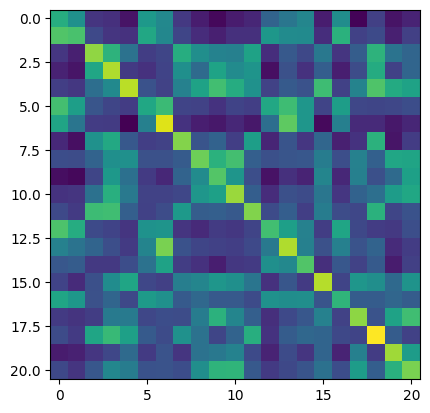

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cos_sim)
plt.show()

if we perform the same operation for dot product similarity, we should return the same results:

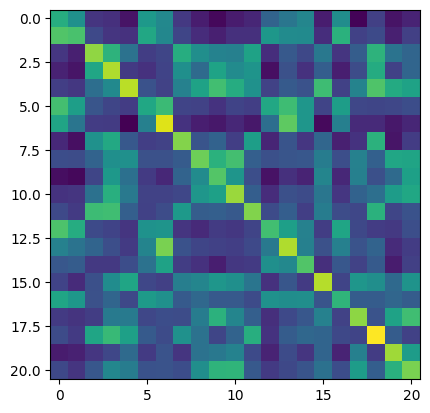

In [ ]:
dot_sim = np.dot(text_emb, img_emb.T)

plt.imshow(cos_sim)
plt.show()

Using the embedding functions of CLIP in this way, we can perform a semantic search across the modalities of text and image in any direction. We can search for images with text, text with images, text with text, and images with images.

# Zero-Shot Classification

We will use the frgfm/imagenette dataset via Hugging Face Datasets.

In [ ]:
!rm -rf ~/.cache/huggingface/datasets/imagenette*

In [ ]:
from datasets import load_dataset

# use a fully compatible image dataset that works with datasets 1.18.0
imagenette = load_dataset("mnist", split="test")

imagenette


Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset mnist downloaded and prepared to /root/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [ ]:
# check labels in the dataset
set(imagenette['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

The dataset contains 10 labels, all stored as integer values. To perform classification with CLIP we need the text content of these labels. Most Hugging Face datasets include the mapping to text labels inside the the dataset

In [ ]:
# labels names
labels = imagenette.info.features['label'].names
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a 0',
 'a photo of a 1',
 'a photo of a 2',
 'a photo of a 3',
 'a photo of a 4',
 'a photo of a 5',
 'a photo of a 6',
 'a photo of a 7',
 'a photo of a 8',
 'a photo of a 9']

Before we can compare labels and photos, we need to initialize CLIP. We will use the CLIP implementation provided by Hugging Face transformers.

In [ ]:
# initialization
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [ ]:
import torch

# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cpu'

Text transformers cannot read text directly. Instead, they need a set of integer values known as token IDs (or input_ids), where each unique integer represents a word or sub-word (known as a token).

We create these token IDs alongside another tensor called the attention mask (used by the transformer’s attention mechanism) using the processor we just initialized.

In [ ]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,   271, 49407])

Using these transformer-readable tensors, we create the label text embeddings like so:

In [ ]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [ ]:
label_emb.min(), label_emb.max()

(np.float32(-2.9168367), np.float32(7.331384))

The vectors that CLIP outputs are not normalized, meaning dot product similarity will give inaccurate results unless the vectors are normalized beforehand. (Alternatively, you can use cosine similarity)

In [ ]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(np.float32(-0.8927377), np.float32(0.9221049))

We will test this with a single image first.

In [ ]:
imagenette[0]['image']

In [ ]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

We must process incoming images to normalize and resize them to fit the input size requirements of the ViT model.

We can create the image embedding with:

In [ ]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [ ]:
img_emb = img_emb.detach().cpu().numpy()

all we need to do is calculate the dot product similarity between our image embedding and the ten label text embeddings. The highest score is our predicted class.

In [ ]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [ ]:
# get index of highest score
pred = np.argmax(scores)
pred

np.int64(7)

In [ ]:

# find text label with highest score
labels[pred]

'7'

We can repeat this logic over the entire frgfm/imagenette dataset to get the classification accuracy of CLIP.

In [ ]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, len(imagenette), batch_size)):
    i_end = min(i + batch_size, len(imagenette))
    images = processor(
        text=None,
        images=imagenette[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
true_preds = []
for i, label in enumerate(imagenette['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

sum(true_preds) / len(true_preds)

0.9870063694267516

CLIP proved to be able to accurately predict image classes with little more than some minor reformating of text labels to create sentences.

Zero-shot image classification with CLIP is a fascinating use case for high-performance image classification with minimal effort and zero fine-tuning required.